In [45]:
import pandas as pd
import numpy as np
from datetime import timedelta, date

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdate
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [46]:
df = pd.read_csv('/Users/marie-noellepage/Documents/Formation/McGill/2. Applied Artificial Intelligence/4. Time Series Analysis Fundamentals/Course 1/covid_canada_assignement.csv')

In [47]:
df.tail()

,date,new_cases,new_deaths
701,2021-12-29,79531.0,56.0
702,2021-12-30,34523.0,21.0
703,2021-12-31,46868.0,49.0
704,2022-01-01,18084.0,9.0
705,2022-01-02,18427.0,15.0


## Preprocessing

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706 entries, 0 to 705
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        698 non-null    object 
 1   new_cases   693 non-null    float64
 2   new_deaths  653 non-null    float64
dtypes: float64(2), object(1)
memory usage: 16.7+ KB


In [49]:
# Check if we have null data
print(df.isnull().any())

date          True
new_cases     True
new_deaths    True
dtype: bool


In [50]:
# Convert date to a datetime column
df['date']= pd.to_datetime(df['date'])

In [51]:
# Duplicate data
df[df.duplicated(keep=False)]

,date,new_cases,new_deaths
513,2021-06-30,552.0,21.0
514,2021-07-01,151.0,19.0
515,2021-07-02,839.0,24.0
516,2021-07-03,342.0,10.0
517,2021-07-04,282.0,12.0
518,2021-07-05,810.0,8.0
519,2021-07-06,290.0,13.0
660,2021-06-30,552.0,21.0
661,2021-07-01,151.0,19.0
662,2021-07-02,839.0,24.0


In [52]:
df1 = df.drop_duplicates()
df1[df.duplicated(keep=False)]

/var/folders/3t/trq2gsfx0z10gvtbxv04fqch0000gn/T/ipykernel_27335/3413464341.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1[df.duplicated(keep=False)]


,date,new_cases,new_deaths
513,2021-06-30,552.0,21.0
514,2021-07-01,151.0,19.0
515,2021-07-02,839.0,24.0
516,2021-07-03,342.0,10.0
517,2021-07-04,282.0,12.0
518,2021-07-05,810.0,8.0
519,2021-07-06,290.0,13.0


In [53]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 0 to 705
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        691 non-null    datetime64[ns]
 1   new_cases   686 non-null    float64       
 2   new_deaths  646 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 21.8 KB


In [54]:
# Create DataFrame with all dates
idx = pd.date_range(df1['date'].min(), df1['date'].max())
frame = {'date': idx}
idx1 = pd.DataFrame(frame)

In [55]:
# merge the 2 dataframe
df2 = pd.merge(df1, idx1, how="right", on=["date", "date"])

# Check if we have null date, all ok now
print(df2.isnull().any())

date          False
new_cases      True
new_deaths     True
dtype: bool


In [56]:
print(df2[df2['new_cases'].isnull()].head())

          date  new_cases  new_deaths
106 2020-05-11        NaN         NaN
107 2020-05-12        NaN         NaN
108 2020-05-13        NaN         NaN
167 2020-07-11        NaN         3.0
168 2020-07-12        NaN         5.0


In [57]:
# Put 0 deaths before March 3, 2020
df2.loc[df2['date'] <= '2020-03-08', 'new_deaths'] = 0

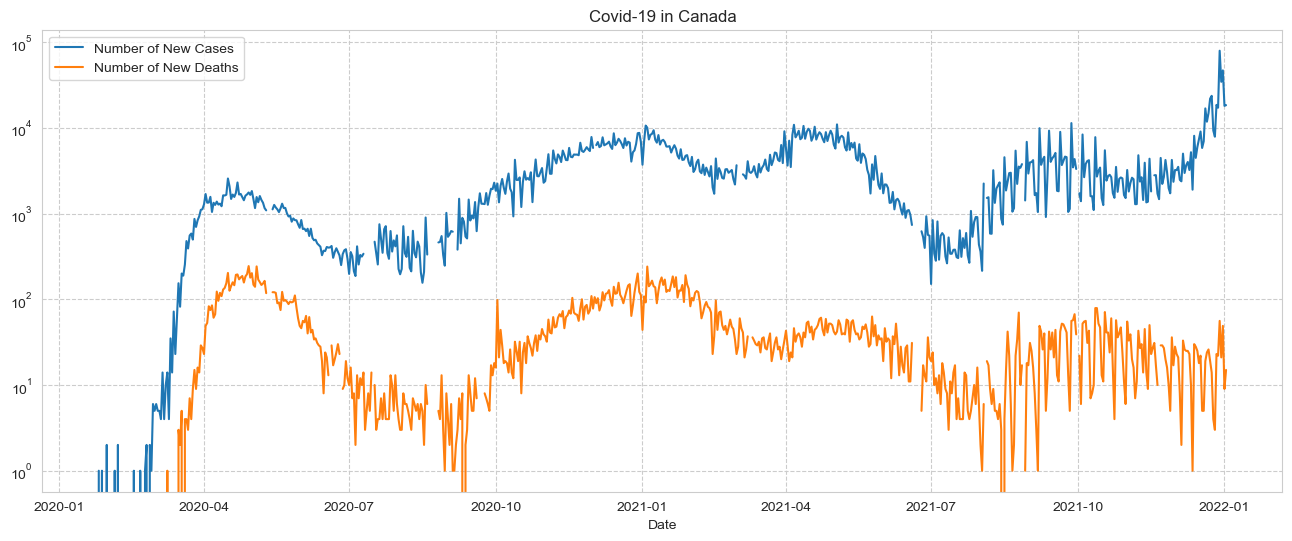

In [58]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df2.date, df2.new_cases, label='Number of New Cases')
ax.set_xlabel("Date")
ax.set_title("Covid-19 in Canada")
ax.plot(df2.date, df2["new_deaths"], label='Number of New Deaths')
ax.set_yscale('log')
ax.legend()
plt.grid(linestyle = '--')
plt.show()

In [59]:
# Interpolate the data
df3 = df2
df3['new_cases'] = round(df2['new_cases'].interpolate(limit=10))
df3['new_deaths'] = round(df2['new_deaths'].interpolate(limit=10))

# Check if we have null date, all ok now
print(df3.isnull().any())

date          False
new_cases     False
new_deaths    False
dtype: bool


In [60]:
# minus value for death !!
df2.describe()

,new_cases,new_deaths
count,708.000000,708.000000
mean,3147.124294,42.833333
std,4685.160823,47.062965
min,0.000000,-1.000000
25%,593.500000,8.000000
50%,1892.500000,27.000000
75%,4275.500000,56.000000
max,79531.000000,244.000000


In [61]:
df2['new_deaths'] = df2['new_deaths'].abs()
df2.describe()

,new_cases,new_deaths
count,708.000000,708.000000
mean,3147.124294,42.836158
std,4685.160823,47.060390
min,0.000000,0.000000
25%,593.500000,8.000000
50%,1892.500000,27.000000
75%,4275.500000,56.000000
max,79531.000000,244.000000


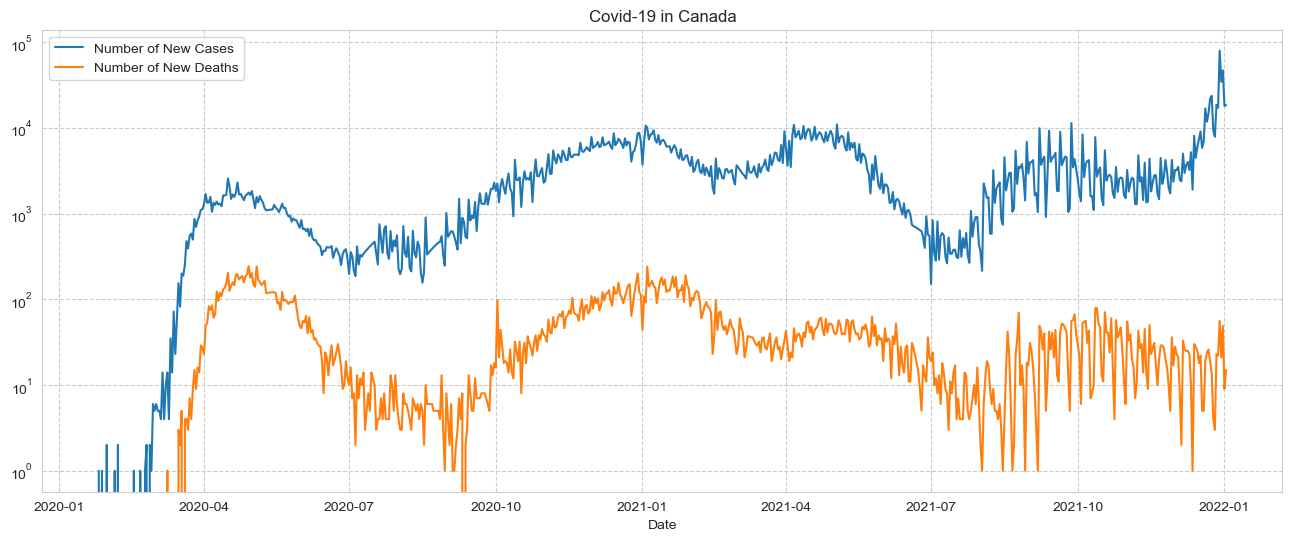

In [62]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df2.date, df2.new_cases, label='Number of New Cases')
ax.set_xlabel("Date")
ax.set_title("Covid-19 in Canada")
ax.plot(df2.date, df2["new_deaths"], label='Number of New Deaths')
ax.set_yscale('log')
ax.legend()
plt.grid(linestyle = '--')
plt.show()

Outliers in begin of October for Deaths ?

## Exploratoring Result

Début vaccination: environ fin février à fin mai 2021 (première dose)
Variants: Alpha, Beta, Gamma, Delta, Omicron.

Alpha (UK): End December,2020
Beta (SA): February, 2021
Gamma (JP): March, 2021
Delta (IN): End April, 2021
Omicron (?): December, 2021

https://ccnmi.ca/variants-preoccupants-de-la-covid-19-au-canada/#subMenuSection1
https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic_in_Canada
https://www.inspq.qc.ca/covid-19/donnees/ligne-du-temps

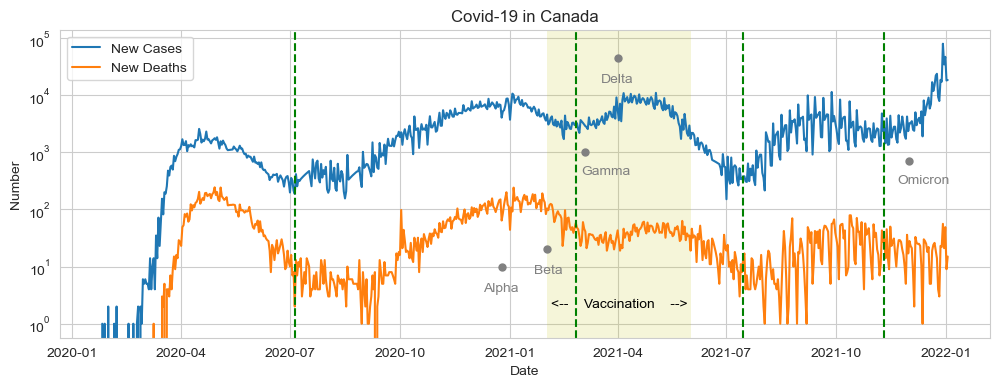

In [63]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(df3.date, df3.new_cases, label='New Cases')
ax.set_xlabel("Date")
ax.set_ylabel("Number")
ax.set_title("Covid-19 in Canada")
ax.plot(df3.date, df3["new_deaths"], label='New Deaths')
ax.set_yscale('log')
ax.legend()
#plt.grid(linestyle = '--')

# vague covid: Alpha, Beta, Gamma, Delta, Omicron
plt.axvline(x = pd.to_datetime('2020-07-05', format = '%Y-%m-%d'), color = 'g', label = 'axvline - full height', linestyle = '--')
plt.axvline(x = pd.to_datetime('2021-02-25', format = '%Y-%m-%d'), color = 'g', label = 'axvline - full height', linestyle = '--')
plt.axvline(x = pd.to_datetime('2021-07-15', format = '%Y-%m-%d'), color = 'g', label = 'axvline - full height', linestyle = '--')
plt.axvline(x = pd.to_datetime('2021-11-10', format = '%Y-%m-%d'), color = 'g', label = 'axvline - full height', linestyle = '--')

#Alpha
plt.plot(pd.to_datetime('2020-12-25'), 10, marker="o", markersize=5, markeredgecolor="gray", markerfacecolor="gray")
plt.annotate('Alpha', xy=(0.455, 0.15), xycoords='axes fraction', color = 'gray')

#Beta
plt.plot(pd.to_datetime('2021-02-01'), 20, marker="o", markersize=5, markeredgecolor="gray", markerfacecolor="gray")
plt.annotate('Beta', xy=(0.51, 0.21), xycoords='axes fraction', color = 'gray')

#Gamma
plt.plot(pd.to_datetime('2021-03-05'), 1000, marker="o", markersize=5, markeredgecolor="gray", markerfacecolor="gray")
plt.annotate('Gamma', xy=(0.56, 0.53), xycoords='axes fraction', color = 'gray')

#Delta
plt.plot(pd.to_datetime('2021-04-01'), 45000, marker="o", markersize=5, markeredgecolor="gray", markerfacecolor="gray")
plt.annotate('Delta', xy=(0.582, 0.83), xycoords='axes fraction', color = 'gray')

#Omicron
plt.plot(pd.to_datetime('2021-12-01'), 700, marker="o", markersize=5, markeredgecolor="gray", markerfacecolor="gray")
plt.annotate('Omicron', xy=(0.9, 0.5), xycoords='axes fraction', color = 'gray')

# Vaccination
#plt.axvline(x = pd.to_datetime('2021-06-01', format = '%Y-%m-%d'), color = 'y', label = 'axvline - full height')
plt.axvspan(pd.to_datetime('2021-02-01'), pd.to_datetime('2021-06-01'), color='y', alpha=0.15, lw=0)
plt.annotate('<--    Vaccination    -->', xy=(0.5284, 0.1), xycoords='axes fraction', color = 'black')

plt.show()

As you can see from the graph, this is a multimodal distribution.

We have 5 waves with different skewness and kurtosis.
-- The waves are separated by the green dotted lines.
-- This is a non-stationary time series, with the presence of trends and seasonality.
-- There is a lag between the new cases and deaths.
-- In the literature, I have read that deaths occur between 2 and 8 weeks after the symptoms of covid.

We can imagine several hypotheses for the difference in waves. But it’s difficult to see the effect of these assumptions (many parameters come into play)
-- In the graph, I put a grey dot for the first time we see the variant in Canada. It certainly takes time for the propagation.
-- Also, the first wave of vaccination is represented by the yellow region (start at the end of the second wave).

#### Correlation in Wave

In [64]:
df4 = df3[['date', 'new_cases']]
df5 = df3[['date', 'new_deaths']]

# add 14 days
#df4['date'] = df4['date'] + pd.DateOffset(14, "d")
df5['date'] = df5['date'] + pd.DateOffset(-14, "d")

# merge the 2 dataframe
df6 = pd.merge(df4,df5,left_on='date',right_on='date')
#df6 = pd.merge(df4, df5, how="right", on=["date", "date"])
df6.dropna()
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694 entries, 0 to 693
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        694 non-null    datetime64[ns]
 1   new_cases   694 non-null    float64       
 2   new_deaths  694 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 21.7 KB


/var/folders/3t/trq2gsfx0z10gvtbxv04fqch0000gn/T/ipykernel_27335/3295312472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['date'] = df5['date'] + pd.DateOffset(-14, "d")


In [65]:
df6['MA_nc'] = df6['new_cases'].rolling(window=7).mean()
df6['MA_nd'] = df6['new_deaths'].rolling(window=7).mean()

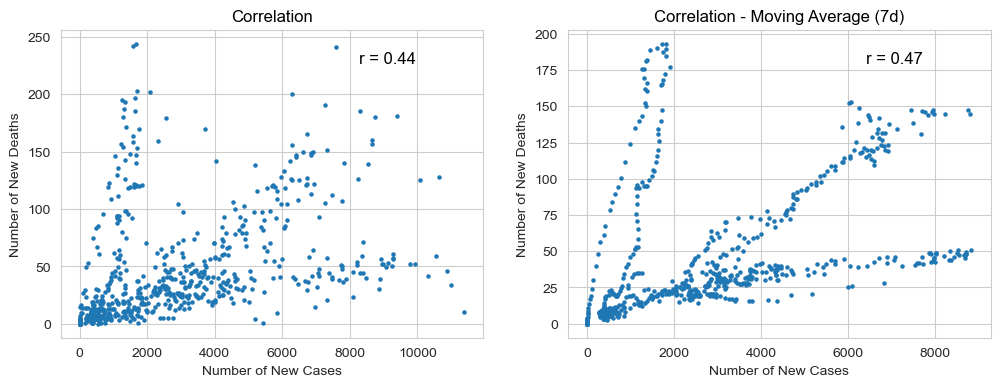

In [66]:
fig,ax=plt.subplots(1,2,figsize=(12,4))

plt.subplot(121)
plt.scatter(df6.new_cases, df6.new_deaths, s=5)
plt.title('Correlation', color='black')
plt.xlabel('Number of New Cases')
plt.ylabel('Number of New Deaths')
s, q = stats.pearsonr(df6.new_cases, df6.new_deaths)
plt.annotate('r = {:.2f}'.format(s), xy=(0.705, 0.891), xycoords='axes fraction', color='black', fontsize=12)

plt.subplot(122)
plt.scatter(df6.MA_nc, df6.MA_nd, s=5)
plt.title('Correlation - Moving Average (7d)', color='black')
plt.xlabel('Number of New Cases')
plt.ylabel('Number of New Deaths')
s, q = stats.pearsonr(df6.MA_nc.dropna(), df6.MA_nd.dropna())
plt.annotate('r = {:.2f}'.format(s), xy=(0.705, 0.891), xycoords='axes fraction', color='black', fontsize=12)

plt.show()

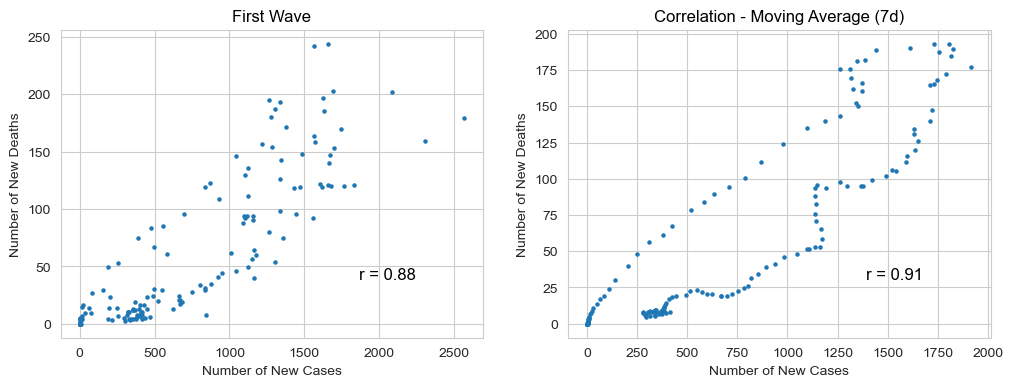

In [67]:
alpha = df6[(df6.date < '2020-07-18')] #'2020-07-05'

fig,ax=plt.subplots(1,2,figsize=(12,4))

plt.subplot(121)
plt.scatter(alpha.new_cases, alpha.new_deaths, s=5)
plt.title('First Wave', color='black')
plt.xlabel('Number of New Cases')
plt.ylabel('Number of New Deaths')
r, p = stats.spearmanr(alpha.new_cases, alpha.new_deaths)
s, q = stats.pearsonr(alpha.new_cases, alpha.new_deaths)
plt.annotate('r = {:.2f}'.format(s), xy=(0.705, 0.191), xycoords='axes fraction', color='black', fontsize=12)

plt.subplot(122)
plt.scatter(alpha.MA_nc, alpha.MA_nd, s=5)
plt.title('Correlation - Moving Average (7d)', color='black')
plt.xlabel('Number of New Cases')
plt.ylabel('Number of New Deaths')
s, q = stats.pearsonr(alpha.MA_nc.dropna(), alpha.MA_nd.dropna())
plt.annotate('r = {:.2f}'.format(s), xy=(0.705, 0.191), xycoords='axes fraction', color='black', fontsize=12)

plt.show()

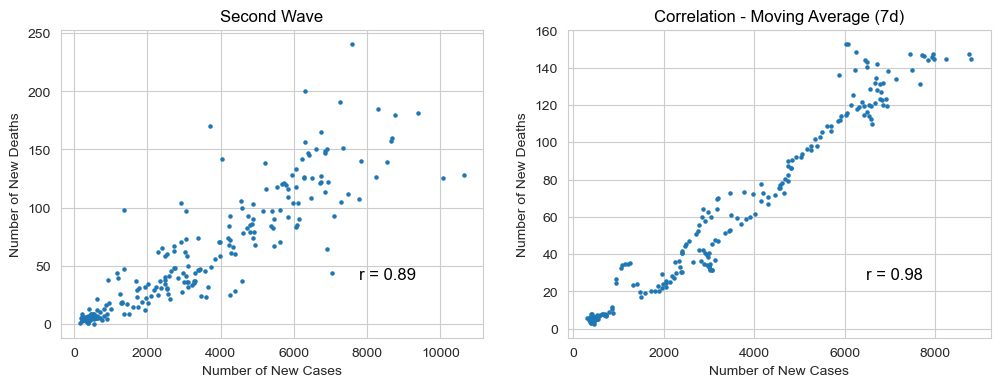

In [68]:
beta = df6[(df6.date >= '2020-07-18') & (df6.date < '2021-03-05')] #(df6.date >= '2020-07-05') & (df6.date < '2021-02-25')

fig,ax=plt.subplots(1,2,figsize=(12,4))

plt.subplot(121)
plt.scatter(beta.new_cases, beta.new_deaths, s=5)
plt.title('Second Wave', color='black')
plt.xlabel('Number of New Cases')
plt.ylabel('Number of New Deaths')
r, p = stats.spearmanr(beta.new_cases, beta.new_deaths)
s, q = stats.pearsonr(beta.new_cases, beta.new_deaths)
plt.annotate('r = {:.2f}'.format(s), xy=(0.705, 0.191), xycoords='axes fraction', color='black', fontsize=12)

plt.subplot(122)
plt.scatter(beta.MA_nc, beta.MA_nd, s=5)
plt.title('Correlation - Moving Average (7d)', color='black')
plt.xlabel('Number of New Cases')
plt.ylabel('Number of New Deaths')
s, q = stats.pearsonr(beta.MA_nc.dropna(), beta.MA_nd.dropna())
plt.annotate('r = {:.2f}'.format(s), xy=(0.705, 0.191), xycoords='axes fraction', color='black', fontsize=12)

plt.show()

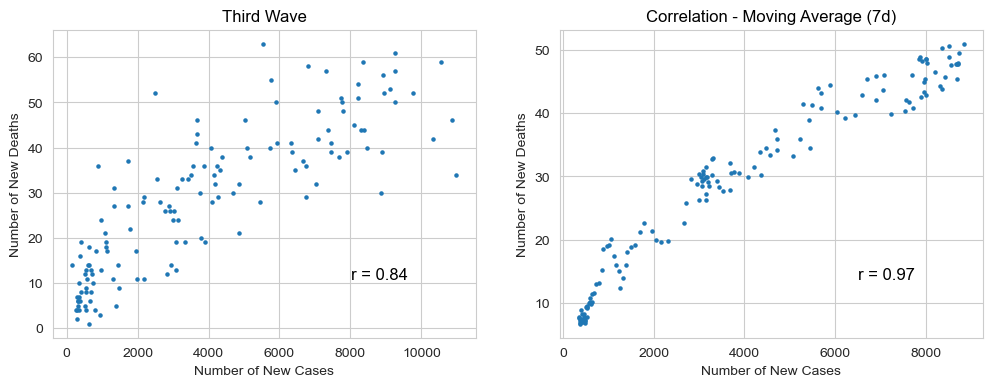

In [69]:
gamma = df6[(df6.date >= '2021-03-05') & (df6.date < '2021-07-23')] #(df6.date >= '2021-02-25') & (df6.date < '2021-07-15')

fig,ax=plt.subplots(1,2,figsize=(12,4))

plt.subplot(121)
plt.scatter(gamma.new_cases, gamma.new_deaths, s=5)
plt.title('Third Wave', color='black')
plt.xlabel('Number of New Cases')
plt.ylabel('Number of New Deaths')
r, p = stats.spearmanr(gamma.new_cases, gamma.new_deaths)
s, q = stats.pearsonr(gamma.new_cases, gamma.new_deaths)
#plt.annotate('Sperman = {:.2f}'.format(r), xy=(0.705, 0.85), xycoords='axes fraction')
plt.annotate('r = {:.2f}'.format(s), xy=(0.705, 0.191), xycoords='axes fraction', color='black', fontsize=12)

plt.subplot(122)
plt.scatter(gamma.MA_nc, gamma.MA_nd, s=5)
plt.title('Correlation - Moving Average (7d)', color='black')
plt.xlabel('Number of New Cases')
plt.ylabel('Number of New Deaths')
s, q = stats.pearsonr(gamma.MA_nc.dropna(), gamma.MA_nd.dropna())
plt.annotate('r = {:.2f}'.format(s), xy=(0.705, 0.191), xycoords='axes fraction', color='black', fontsize=12)

plt.show()

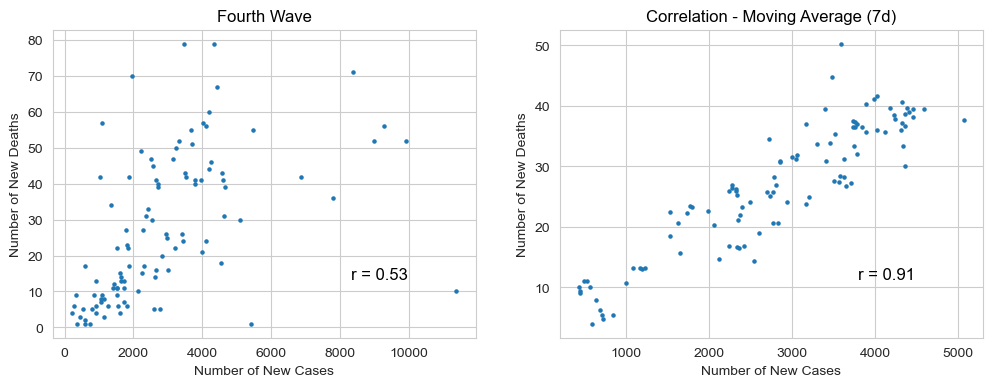

In [70]:
delta = df6[(df6.date >= '2021-07-23') & (df6.date < '2021-11-04')] #(df6.date >= '2021-07-15') & (df6.date < '2021-11-10')

fig,ax=plt.subplots(1,2,figsize=(12,4))

plt.subplot(121)
plt.scatter(delta.new_cases, delta.new_deaths, s=5)
plt.title('Fourth Wave', color='black')
plt.xlabel('Number of New Cases')
plt.ylabel('Number of New Deaths')
r, p = stats.spearmanr(delta.new_cases, delta.new_deaths)
s, q = stats.pearsonr(delta.new_cases, delta.new_deaths)
p#lt.annotate('Sperman = {:.2f}'.format(r), xy=(0.705, 0.85), xycoords='axes fraction')
plt.annotate('r = {:.2f}'.format(s), xy=(0.705, 0.191), xycoords='axes fraction', color='black', fontsize=12)

plt.subplot(122)
plt.scatter(delta.MA_nc, delta.MA_nd, s=5)
plt.title('Correlation - Moving Average (7d)', color='black')
plt.xlabel('Number of New Cases')
plt.ylabel('Number of New Deaths')
s, q = stats.pearsonr(delta.MA_nc.dropna(), delta.MA_nd.dropna())
plt.annotate('r = {:.2f}'.format(s), xy=(0.705, 0.191), xycoords='axes fraction', color='black', fontsize=12)

plt.show()

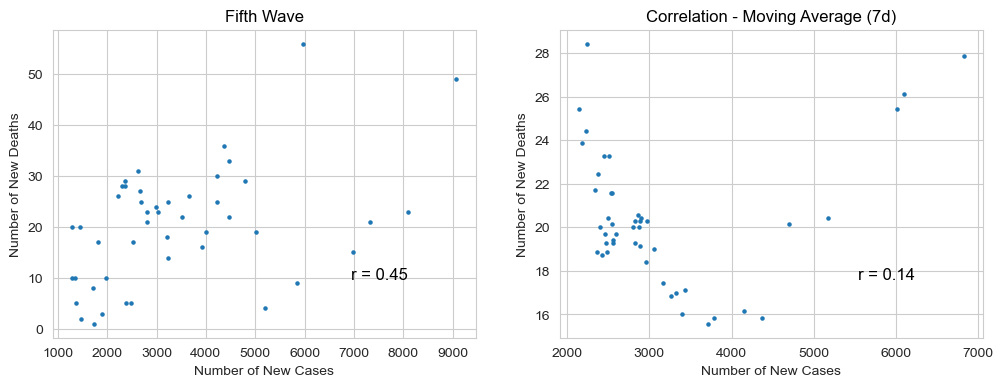

In [71]:
omicron = df6[(df6.date >= '2021-11-04')] #df6.date >= '2021-11-10'

fig,ax=plt.subplots(1,2,figsize=(12,4))

plt.subplot(121)
plt.scatter(omicron.new_cases, omicron.new_deaths, s=5)
plt.title('Fifth Wave', color='black')
plt.xlabel('Number of New Cases')
plt.ylabel('Number of New Deaths')
r, p = stats.spearmanr(omicron.new_cases, omicron.new_deaths)
s, q = stats.pearsonr(omicron.new_cases, omicron.new_deaths)
#plt.annotate('Sperman = {:.2f}'.format(r), xy=(0.705, 0.85), xycoords='axes fraction')
plt.annotate('r = {:.2f}'.format(s), xy=(0.705, 0.191), xycoords='axes fraction', color='black', fontsize=12)

plt.subplot(122)
plt.scatter(omicron.MA_nc, omicron.MA_nd, s=5)
plt.title('Correlation - Moving Average (7d)', color='black')
plt.xlabel('Number of New Cases')
plt.ylabel('Number of New Deaths')
s, q = stats.pearsonr(omicron.MA_nc.dropna(), omicron.MA_nd.dropna())
plt.annotate('r = {:.2f}'.format(s), xy=(0.705, 0.191), xycoords='axes fraction', color='black', fontsize=12)

plt.show()

I added 14 day lag on time for the new cases to calculate the Pearson correlation.
Since the series is a multimodal distribution, I performed the calculation for each wave separately.

It can be seen that the correlation starts to decrease from the third wave,
Which coincides with the first wave of vaccination.

Thus, it seems that vaccination has a positive effect on deaths.
But this assumption needs to be validated with the severity of variants and other data on vaccination not included in the dataset.

But we need be careful:
We have different variance between wave, maybe it would be better to standardize the data before the calculation with a moving average example.

Also, dividing the time series into segments can help to identify time periods 
where the two series may be more strongly correlated. 

However, this method does not account for the changing statistical properties of the time series over time, which can affect the correlation between segments.


#### ACF & PACF

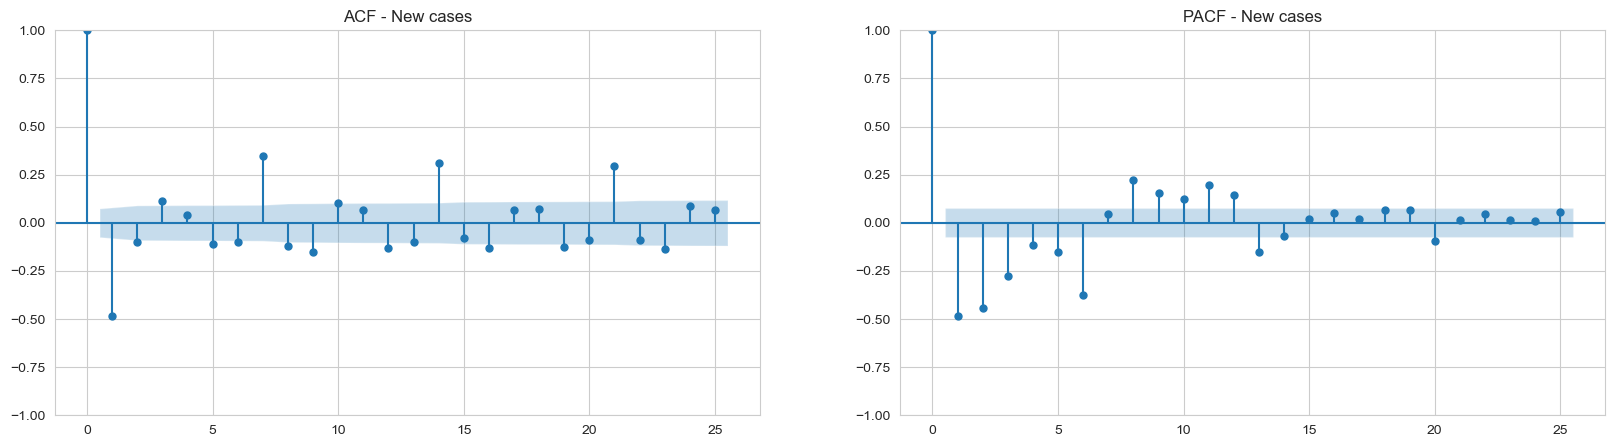

In [72]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot_acf(df6['new_cases'].diff().dropna(), lags=25, title='ACF - New cases', ax=ax[0])
plot_pacf(df6['new_cases'].diff().dropna(), lags=25, title='PACF - New cases', ax=ax[1])
plt.show()

Autocorelation on new cases (season of 7 days)

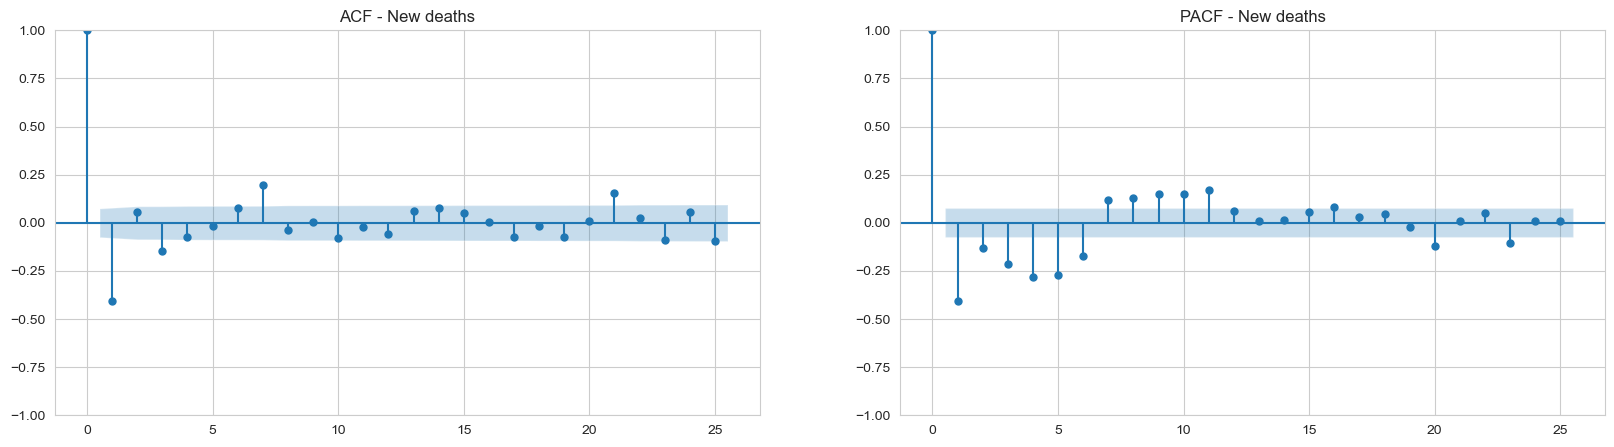

In [73]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

plot_acf(df6['new_deaths'].diff().dropna(), lags=25, title='ACF - New deaths', ax=ax[0])
plot_pacf(df6['new_deaths'].diff().dropna(), lags=25, title='PACF - New deaths', ax=ax[1])
plt.show()

#### Seasonal Decomposition

In [84]:
df7 = df3[(df3.date >= '2020-03-01')]
df7['log_nc'] = np.log(df7['new_cases'])

/var/folders/3t/trq2gsfx0z10gvtbxv04fqch0000gn/T/ipykernel_89411/1753039431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['log_nc'] = np.log(df7['new_cases'])


In [86]:
df7.head()

,date,new_cases,new_deaths,log_nc
35,2020-03-01,5.0,0.0,1.609438
36,2020-03-02,6.0,0.0,1.791759
37,2020-03-03,5.0,0.0,1.609438
38,2020-03-04,5.0,0.0,1.609438
39,2020-03-05,4.0,0.0,1.386294


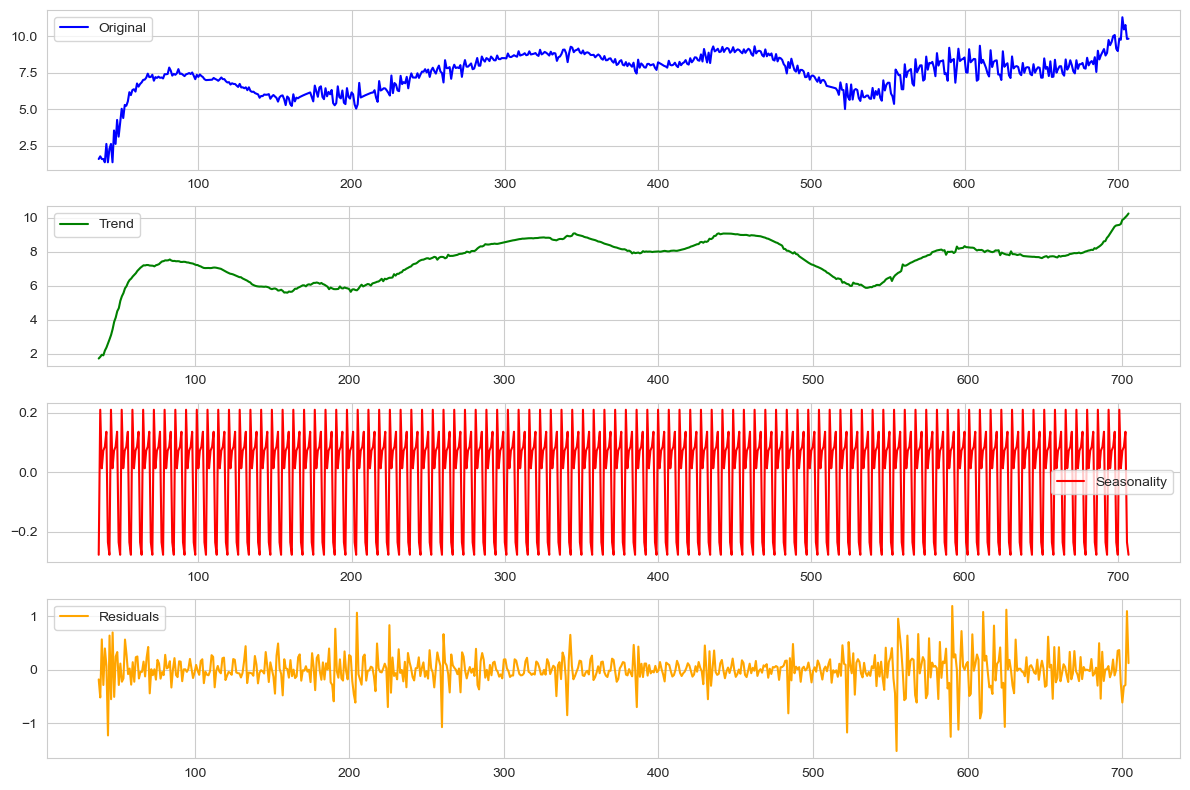

In [87]:
# Graph of decomposition (trend, seasonal, noise)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df7['log_nc'], model='additive',period= 7)

# get the trend, seasonality and noise 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df7['log_nc'], label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="green")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="red")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="orange")
plt.legend(loc='best')
plt.tight_layout()